In [39]:
# linear algebra
import math
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# display
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML

# plot
import matplotlib.pyplot as plt
import matplotlib

# progress bar
from tqdm import tqdm

# functions
from functions import *

# support for automatic reloading
%load_ext autoreload
%autoreload 2

from models.unn_loss import FCNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_65625/4168577221.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))/2
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_65625/4168577221.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()/2


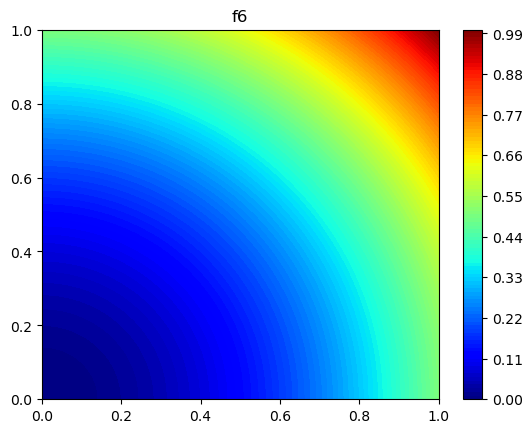

In [40]:
# define space
X_tensor_f6 = torch.linspace(0, 1, 100)
Y_tensor_f6 = torch.linspace(0, 1, 100)
X_tensor_f6_2D, Y_tensor_f6_2D = torch.meshgrid(X_tensor_f6, Y_tensor_f6)
Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))/2

X_tensor_2d = torch.cat((X_tensor_f6_2D.unsqueeze(2), Y_tensor_f6_2D.unsqueeze(2)), dim=1).view(-1, 2)
Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()/2

# Z6_tensor = (Z6_tensor - torch.min(Z6_tensor))/ (torch.max(Z6_tensor) - torch.min(Z6_tensor))

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f6')
# plt.savefig('figures/f6.png')
plt.show()

In [41]:
# NN parameters
n_features_in = 2
N_HIDDEN = [128, 128, 128, 128]
LR = 1e-2

# defining the model
model_f1 = FCNet(in_features=n_features_in, out_features=1, n_hidden=[8, 8, ])

# defining the loss function, the optimizer and the scheduler
criterion_f1 = nn.MSELoss()
optimizer_f1 = torch.optim.Adam(model_f1.parameters(), lr=LR)
scheduler_f1 = torch.optim.lr_scheduler.StepLR(optimizer_f1, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

In [42]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f1, input_size=(100, n_features_in), graph_name=model_f1.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [43]:
# training loop
EPOCHS = 500
BATCH_SIZE = 128

losses_f1_total = []
losses_f1 = []
losses_f1_reg = []
s, p = 1, 1

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses_total = []
    train_losses = []
    train_losses_reg = []

    # permutation = torch.randperm(n_samples_train)

    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f1.train()

        # choose batch
        idx = slice(i, i+BATCH_SIZE) # permutation[i: i+BATCH_SIZE]
        batch_x, batch_y = X_tensor_2d[idx], Z6_tensor[idx]

        # zero grad
        optimizer_f1.zero_grad()

        # forward pass
        output = model_f1(batch_x)

        # compute loss
        loss = criterion_f1(output, batch_y.unsqueeze(1))
        reg_loss = model_f1.monotonicity_loss(batch_x, torch.eye(2))

        loss_total = (1-p) * loss + p * s * reg_loss

        # backward pass
        loss_total.backward()
        train_losses_total.append(loss_total.item())
        train_losses.append(loss.item())
        train_losses_reg.append(reg_loss.item())

        # update weights
        optimizer_f1.step()

    # update s
    reg_loss_magn = np.mean(train_losses_reg)
    loss_magn = np.mean(train_losses)
    r = loss_magn/(reg_loss_magn + 1e-6)
    s = 10**(np.floor(math.log10(r)))

    # update LR
    scheduler_f1.step()

    losses_f1_total.append(np.mean(train_losses_total))
    losses_f1.append(np.mean(train_losses))
    losses_f1_reg.append(np.mean(train_losses_reg))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss total {losses_f1_total[-1]:.7f} - Loss {losses_f1[-1]:.7f} - Reg loss {losses_f1_reg[-1]:.7f} - LR {optimizer_f1.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [01:28<00:00,  5.64it/s, Loss total 0.0000001 - Loss 0.0386479 - Reg loss 0.0000000 - LR 0.0023730]


Epoch 500 - train loss: 0.038647938272149504
Epoch 500 - train loss total: 7.344603087174279e-08
Epoch 500 - test loss: 0.03636273369193077
Epoch 500 - test loss total: 1.5901222229003906


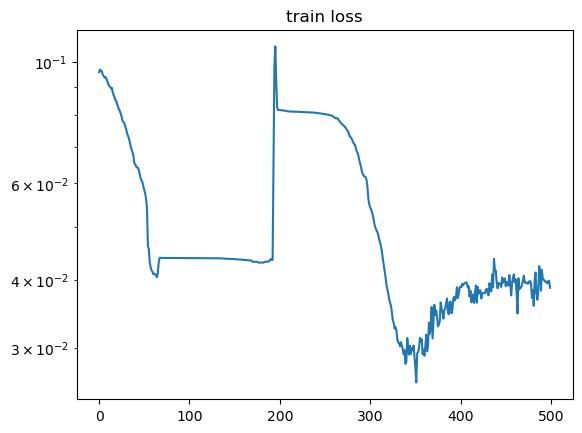

In [44]:
# prediction
with torch.no_grad():
    model_f1.eval()
    y_pred = model_f1(X_tensor_2d)

final_loss = criterion_f1(y_pred, Z6_tensor.unsqueeze(1))
reg_loss = model_f1.monotonicity_loss(X_tensor_2d, torch.eye(2))
loss_total = loss + 1e2* reg_loss

print(f"Epoch {EPOCHS} - train loss: {losses_f1[-1]}")
print(f"Epoch {EPOCHS} - train loss total: {losses_f1_total[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")
print(f"Epoch {EPOCHS} - test loss total: {loss_total}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f1, label='train loss')
plt.yscale('log')
plt.title('train loss')
# plt.savefig('figures/train_loss_f6.png')
plt.show()

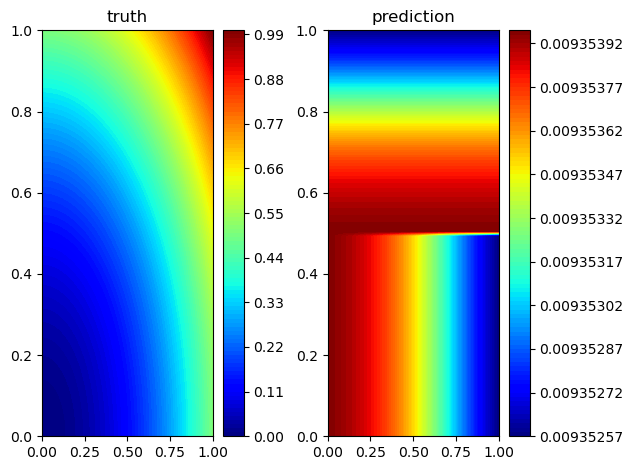

In [45]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

# plt.savefig('figures/truth_prediction_f6.png')
plt.show()